# Lecture 3.10: Random Forests

[**Lecture Slides**](https://docs.google.com/presentation/d/1vpWA5RgGDv69ahG3B7kh4JozRu8LIxb29GMfRLk3KjQ/edit?usp=sharing)

This lecture, we are going to train and compare a decision tree and a random forest on a real dataset.

**Learning goals:**
- train a decision tree classifier
- train a random forest classifier
- visualize and compare the model decision boundaries
- analyse the effect of regularization parameters `max_depth` & `min_samples_leaf`
- train a random forest regressor

## 1. Introduction

Let's try to improve our fake banknote detector from lecture 3.9. 🕵️‍♀️ We'll use the same [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication), and try to solve the fake/genuine classification task.

## 2. Classification

### 2.1 Data Munging

Let's load our `.csv` into a pandas `DataFrame`, and have a look at the dataset:

In [1]:
import pandas as pd

df = pd.read_csv('bank_note.csv')

df.head()

,feature_1,feature_2,feature_3,feature_4,is_fake
0,1.121806,1.149455,-0.975970,0.354561,0
1,1.447066,1.064453,-0.895036,-0.128767,0
2,1.207810,-0.777352,0.122218,0.618073,0
3,1.063742,1.295478,-1.255397,-1.144029,0
4,-0.036772,-1.087038,0.736730,0.096587,0


In [2]:
df.describe()

,feature_1,feature_2,feature_3,feature_4,is_fake
count,1372.000000,1.372000e+03,1.372000e+03,1.372000e+03,1372.000000
mean,0.000000,4.143106e-17,1.035777e-17,-5.437827e-17,0.444606
std,1.000365,1.000365e+00,1.000365e+00,1.000365e+00,0.497103
min,-2.630737,-2.675252e+00,-1.551303e+00,-3.502703e+00,0.000000
25%,-0.776547,-6.188189e-01,-6.899455e-01,-5.817379e-01,0.000000
50%,0.021974,6.771828e-02,-1.812706e-01,2.880644e-01,0.000000
75%,0.840243,8.338757e-01,4.135174e-01,7.553713e-01,1.000000
max,2.249008,1.879908e+00,3.836586e+00,1.733680e+00,1.000000


Recall that we are dealing with 4 features, and one binary label. The features are standardized, so no further preprocessing is necessary.

We can create our feature matrix, `X`, and our label vector, `y`:

In [3]:
X = df[['feature_2', 'feature_4']].values
y = df['is_fake'].values

And we can visualize the dataset to remember the complexity of the classification task:

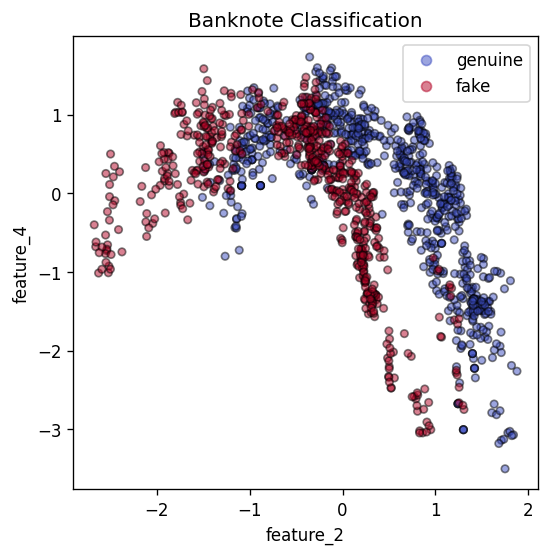

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5), dpi=120)
ax = fig.add_subplot()

scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
ax.set_xlabel('feature_2')
ax.set_ylabel('feature_4')
ax.set_title('Banknote Classification')
handles, labels = scatter.legend_elements()
ax.legend(handles=handles, labels=['genuine', 'fake']);

The data is _not separable_ , and the relationship between `feature_2` and `feature_4` is _non-linear_. This should make a good challenge for our decision trees! 🌳

### 2.2 Training

#### 2.2.1 Decision Trees

We can use our favourite sklearn model api with `.fit` and `.predict()`. The class for decision tree classifiers is ... `DecisionTreeClassifier` 😏

In [5]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=0)
tree_clf = tree_clf.fit(X, y)

🧠 Can you list all the steps that sklearn had to go through to train this decision tree with the function `.fit()`? 

We usually try to investigate our model parameters after fitting the model. However, decision trees don't have a vector $\theta$ or support vectors, they are _non-parametric models_. In the lecture slides, we introduced decision trees as nested if-statements. So instead, we can investigate their _decision node splits_.

Let's check the _depth_ of our decision tree. Remember this is the maximal length of a decision _branch_. We can also output the total number of leaf nodes:

In [6]:
print(f'This decision tree has depth {tree_clf.get_depth()}, and contains {tree_clf.get_n_leaves()} leaves')

This decision tree has depth 27, and contains 167 leaves


27 decision levels, that's quite a big tree we've grown here! 🌳

Recall that decision trees make predictions by stepping through their decision nodes. By visualizing our tree's nodes, we can interpret its predictions. Decision trees are sometimes called white box models, because we can examine their inner workings. More on model explainability next chapter! 📙

We'll use sklearn's `.plot_tree()` method to visualize the decision nodes. We must _truncate_ the tree with a `max_depth=2`, or else the visualization will be too big to fit on the screen.

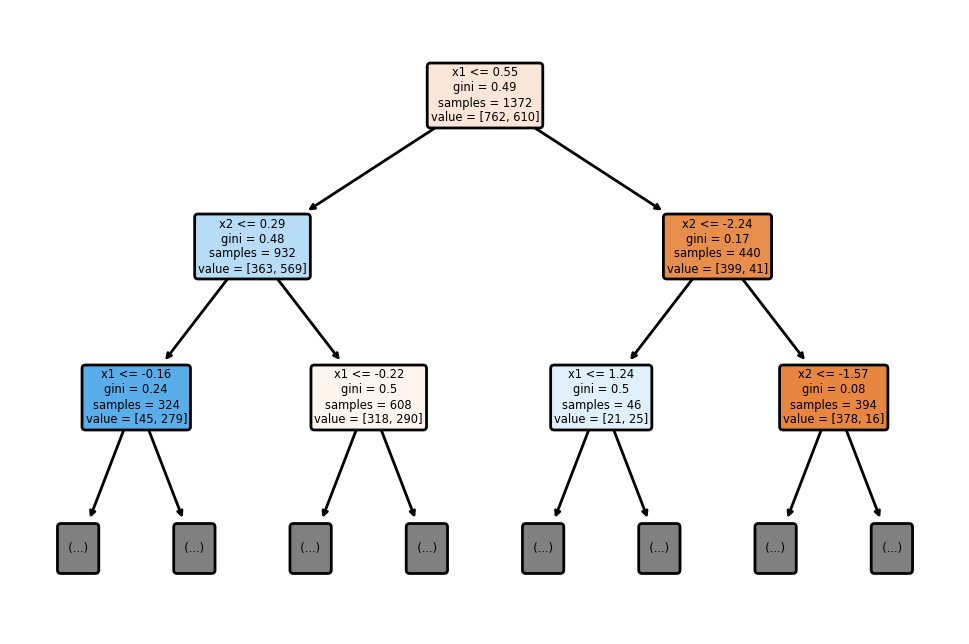

In [7]:
from sklearn.tree import plot_tree

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
plot_tree(ax=ax, decision_tree=tree_clf, filled=True, max_depth=2, feature_names=['x1', 'x2'], rounded=True, precision=2);

This visualization is packed with information 🤤

- The first line of each node defines its _split_. i.e The feature and the value which partitions incoming data into its children nodes.

- The second line indicates the _gini impurity_ metric associated with each split on the training dataset. Remember, low gini impurity implies homogeneity and is therefore a good thing!

- The third line displays the number of training examples belonging to that node.

- The fourth line shows the _class split_ of this node. i.e How many genuine vs fake bills were present in this node during training. We expect this gap to get larger as we go deeper down the branches.

- The node color represents the same information as the fourth line: bluer nodes contain more genuine bills, redder nodes contain more fake bills. We also expect these hues to get more pronounced closer to the leafs nodes.

Note that all lines except the first tell information specific to _training_. All that is needed for prediction is the feature values of the splits, and the class attribution of each leaf node.

🧠 Take your time to understand this graph and how it was "greedily" built during training.

These splits (if-statements) shape the model's decision boundary. We'd like to visualize this along with the dataset. Since we'll be visualizing a lot of classifications in 2D throughout this notebook, let's write some helper functions (code from the [sklearn documentation](https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html)).

Just like last lecture, the function `.plot_classification()` plots both the dataset and the decision boundary for a given feature matrix `X`, label vector `y`, and a classifier `clf`:

In [8]:
import numpy as np
from matplotlib.lines import Line2D

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_decision_boundary(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    plot_decision_boundary(ax, clf, xx, yy, **params)


def plot_classification(ax, X, y, clf):
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
    scatter = ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=1.0)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Bank Notes Classification')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=['genuine', 'fake'])

We can now easily plot our decision tree classifier's predictions 🎨:

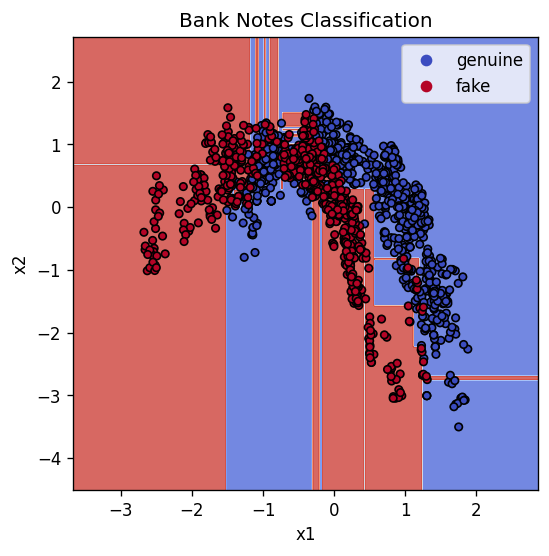

In [9]:
fig = plt.figure(figsize=(5,5), dpi=120)
ax = fig.add_subplot()
plot_classification(ax, X, y, tree_clf)

That's a funky decision boundary! 😳 It is made exclusively of vertical and horizontal lines because predictions are made from a succession of if-statements on single features. The very thin rectangular areas are typical of _overfit_ decision trees. They try to fit single data points instead of the underlying patterns of the data.

In the lecture slides, we have mentioned a powerful remedy for overfit decision trees: random forests.

#### 2.2.2 Random Forests

Let's train a random forest on the same dataset.

In [10]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=0)
forest_clf = forest_clf.fit(X, y)

🧠 Can you list all the steps that sklearn had to go through to train this random forest? Take your time, there a lot of things going on in that `.fit()` function!

Recall that random forests are an _ensemble_ of decision trees, and we can retrieve each tree with the `.estimators_` field:

In [11]:
print(f'This random forest is an ensemble of {len(forest_clf.estimators_)} decision trees')

This random forest is an ensemble of 100 decision trees


In [12]:
forest_clf.estimators_[5]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1537364731, splitter='best')

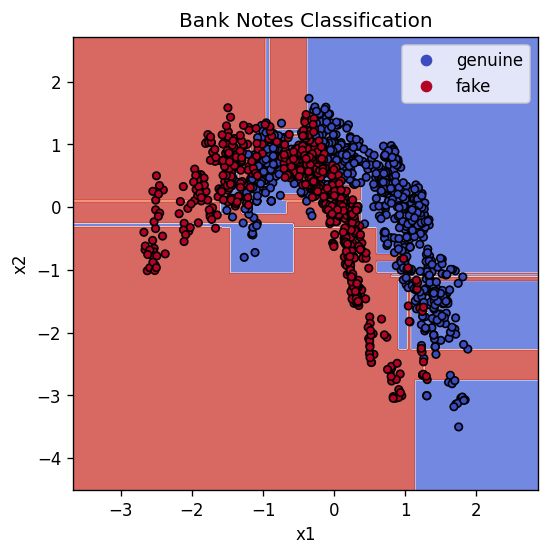

In [13]:
#Seeing how forest_clf.estimators_[5] looks like 

fig = plt.figure(figsize=(5,5), dpi=120)
ax = fig.add_subplot()
plot_classification(ax, X, y, forest_clf.estimators_[5])

Since we don't have the space to visualize 100 decision tree flow chart, let's directly plot the random forest's decision boundary with our helper function:

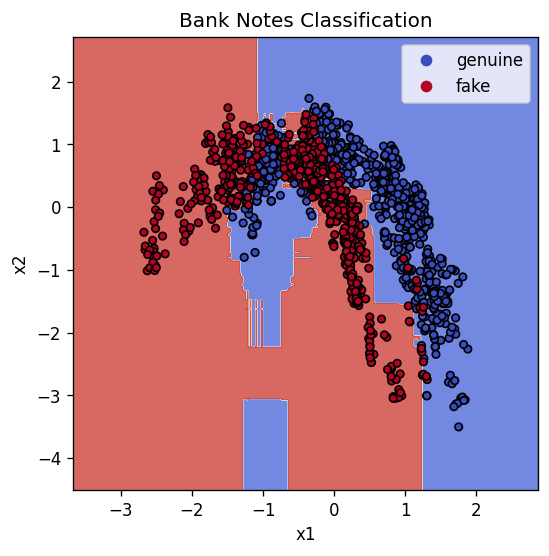

In [14]:
fig = plt.figure(figsize=(5,5), dpi=120)
ax = fig.add_subplot()
plot_classification(ax, X, y, forest_clf)

The decision boundary is considerably different from the single decision tree. It is still only made of vertical and horizontal lines, but this time it is far more _detailed_. This is because these are the combined lines of 100 decision boundaries.

Recall that these predictions are made by majority voting. For each point in this graph, all the predictions "votes" from the 100 decision trees are rounded up: 
- those where there are more `fake` votes than `genuine` are shown in red
- those where there are more `genuine` than `fake` votes, are shown in blue

#### 2.2.3 Comparison

Let's compare these two models with another type of classifier: a RBF kernel SVM (see lecture 3.9).

Just like last lecture, we can write a small loop to visualize these models next to eachother. We'll then train a non-linear SVM to compare with the decision tree and the random forest:

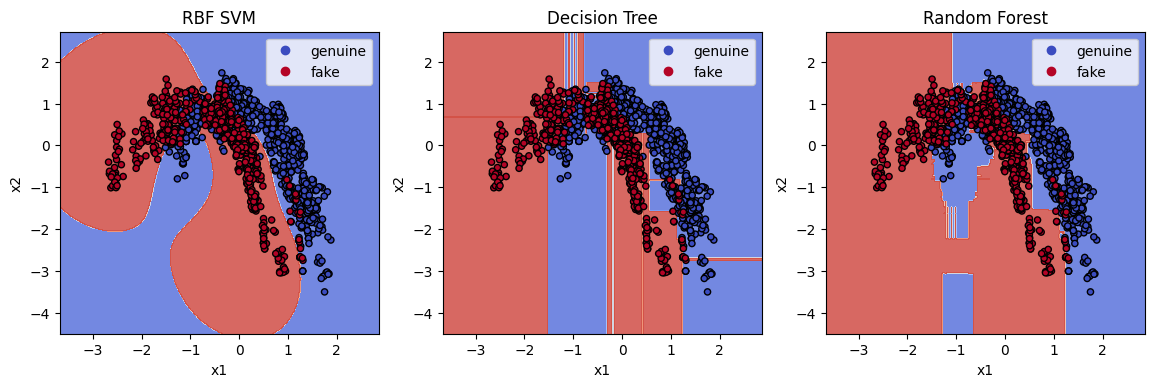

In [15]:
def compare_classification(X, y, clfs, titles):
    fig = plt.figure(figsize=(14, 4), dpi=100)
    for i, clf in enumerate(clfs):
        ax = fig.add_subplot(1, len(clfs), i+1)
        plot_classification(ax, X, y, clf)
        ax.set_title(titles[i])
        
        
from sklearn.svm import SVC

svm_rbf = SVC(kernel='rbf', random_state=0)
svm_rbf = svm_rbf.fit(X, y)

compare_classification(X, y, [svm_rbf, tree_clf, forest_clf], ['RBF SVM', 'Decision Tree', 'Random Forest'])

All three models exhibit non-linear decision boundaries, but in very different ways. 
- the SVM is busy maximizing the margin shaped by its distance features, creating smooth "blobs" that follow the edges of the data
- the decision tree tries its best to split the dataset with single feature thresholds, splitting the data into nested rectangles
- the random forest averages random variations of these rectangles, creating very detailed polygons. 

Notice that despite acting as a regularizer for the decision tree model, the random forest is _still_ somewhat overfit to the dataset.


🧠🧠 None of these models seem to be able to correctly predict the fake examples near $[1, -1]$. Why is that?

🧠🧠 In your opinion, which is the algorithm most adapted to this dataset and classification task? Why?

### 2.3 Prediction

Let's test our models by asking them to predict a banknote in the small `genuine` cluster on the left hand side of the graphs above.  We'll use $feature\_1 = -1; feature\_2 = 0$:

In [16]:
x_predict = np.array([-1, 0]).reshape(1, 2)
print(f'Features: {x_predict}')

svm_rbf_prediction = svm_rbf.predict(x_predict)
print(f'RBF SVM prediction: {svm_rbf_prediction}')

tree_clf_prediction = tree_clf.predict(x_predict)
print(f'Decision Tree prediction: {tree_clf_prediction}')

forest_clf_prediction = forest_clf.predict(x_predict)
print(f'Decision Tree prediction: {forest_clf_prediction}')

Features: [[-1  0]]
RBF SVM prediction: [0]
Decision Tree prediction: [0]
Decision Tree prediction: [0]


All three models are able to correctly predict features in this cluster thanks to their non-linear decision boundary. 🤩

### 2.4 Analysis

#### 2.4.1 Regularization: max depth

We have successfully trained decision trees, and prevented them from overfitting by _ensembling_ them into a random forest. But we haven't played with a different regularization hyperparameter: `max_depth`.

`max_depth` "cuts" branches which are too long. i.e During training, nodes deeper than `max_depth` automatically become leaf nodes. 

Let's directly visualize the effect of this hyperparameter on the models's classification by plotting decision boundaries for different values of `max_depth`. We'll be using the handy `**kwargs` as arguments, here's a great [blog post](https://realpython.com/python-kwargs-and-args/) if you haven't heard about them.

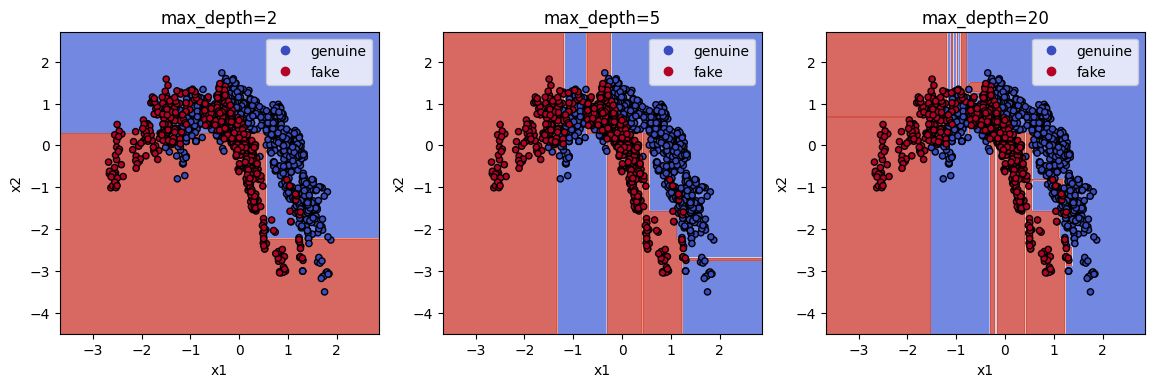

In [17]:
def train_tree(X, y, **kwargs):
    tree_clf = DecisionTreeClassifier(random_state=0, **kwargs)
    return tree_clf.fit(X, y)

max_depth_values = [2, 5, 20]
trees = [train_tree(X, y, max_depth=m) for m in max_depth_values]
titles = [f'max_depth={max_depth}' for max_depth in max_depth_values]

compare_classification(X, y, trees, titles)

We can clearly see the regularizing effect of "cutting off" trees branches after a certain depth. `max_depth` has for effect of reducting the number of nested if-statements, and therefore limiting the number of "angles" in the decision boundary.

#### 2.4.2 Regularization: number of decision trees

One important hyperparameter in the training of a random forest is the number of decision trees which form the ensemble. In sklearn, this is controlled with the `n_estimators` argument. Let's check out its effects on the combined model:

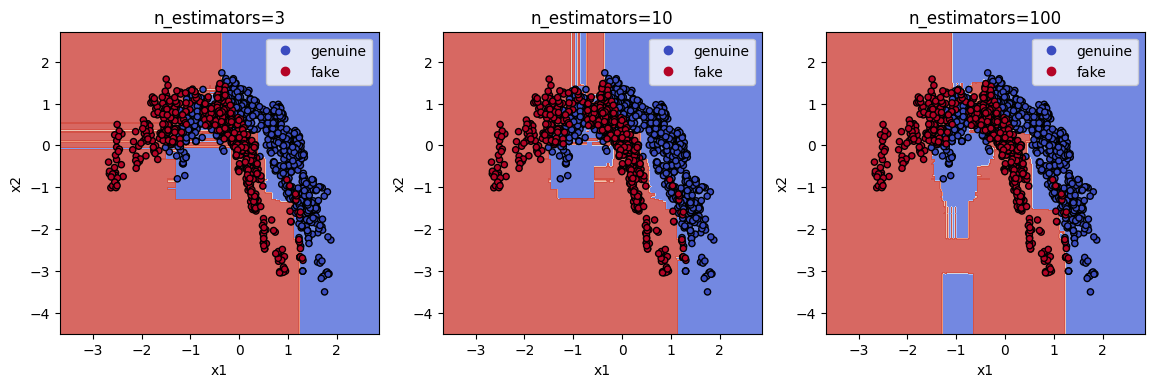

In [18]:
def train_forest(X, y, **kwargs):
    clf = RandomForestClassifier(random_state=0, **kwargs)
    return clf.fit(X, y)

n_estimators_values = [3, 10, 100]
forests = [train_forest(X, y, n_estimators=n) for n in n_estimators_values]
titles = [f'n_estimators={n}' for n in n_estimators_values]

compare_classification(X, y, forests, titles)

A bigger ensemble means less overfitting, and a more accurate combined model. However, more `n_estimators` increases the training time! Try training a random forest with 5000 decision trees and count the seconds tick away 😪

In [ ]:
train_forest(X, y, n_estimators=5000)

#### 2.4.3 Regularization: minimum samples per leaf

💪💪 Investigate the effect of the `min_samples_leaf` argument on a random forest.
- you can use the exact same code structure as the section above
- you don't have to redefine the function `.train_forest()`, since `**kwargs` will work with any _named argument_.
- pick a suitable range of parameter values. You can always change them and run the cell again!
- the unit test is having nice looking graphs 🙃


🧠 Define the effect of the `min_samples_leaf` parameter. It might help to check out the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

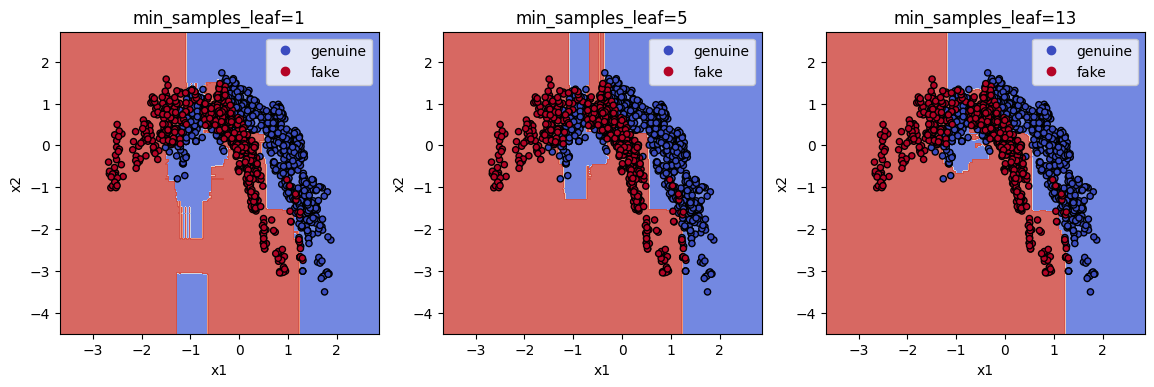

In [19]:
min_samples_leaf_values = [1,5,13]
forests = [train_forest(X, y, min_samples_leaf=n) for n in min_samples_leaf_values]
titles = [f'min_samples_leaf={n}' for n in min_samples_leaf_values]

compare_classification(X, y, forests, titles)

🧠🧠 How does `min_samples_leaf` affect the model's generalization? Why?

Answer : `min_samples_leaf` is the minimum number of samples required to be at a leaf node.

The more it is , the less number of spilts happen as they must have the above criteria. Therefore min_samples_leaf makes the model more generalized when it increases. (To the point that it can become under-fit)


## 3. Regression

As mentioned in the lecture slides, decision trees can solve regression tasks. They do so by using _variance reduction_ instead of _homogeneity metrics_ to split each node, and by assigning _numerical values_ to each leaf node.

We'd like to try this out this on our "instagram planning" dataset, and aim to predict the `actual_minutes` spent online from the originally `planned_minutes` (see notebook 3.7 for more a more detailed exploration of this dataset).

Except this time, _you_ are going to compare and analyse these regression models! 

💪💪💪 Train, analyse a decision tree regressor & a random forest regressor on the instagram planning dataset. Some helper functions are supplied so you can focus on the machine learning bits 😎. Here's a list of the steps you should be taking to lead your analysis:
- load the `instagram_planning.csv` dataset into a `DataFrame`
- optionally visualize this dataset to refresh your memory
- create a feature matrix, `X`, and a label vector, `y`
- fit a [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) model to the data (check the official documentation for details)
- optionally visualize the decision tree's nodes to understand its prediction logic with `.plot_tree()`
- fit a [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model to the data (check the official documentation for details)
- plot and compare their decision boundaries with `.compare_regression()`, which has the exact same interface as `.compare_classification()`.
- the unit test is having nice looking graphs 🙃


In [20]:
def plot_regression(ax, X, y, reg):

    # plot the examples
    ax.scatter(X, y, alpha=0.6)

    # create feature matrix
    xmin, xmax = ax.get_xlim()
    x_line = np.linspace(xmin, xmax, 30).reshape(-1, 1)
    
    # predict
    y_line = reg.predict(x_line)

    # plot the hypothesis
    ax.plot(x_line, y_line, c='g', linewidth=3)

    # formatting
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('planned online time (min)')
    ax.set_ylabel('time spent online (min)')
    ax.set_title('Online Procrastination');
    
def compare_regression(X, y, regs, titles):
    fig = plt.figure(figsize=(14, 4), dpi=100)
    for i, reg in enumerate(regs):
        ax = fig.add_subplot(1, len(regs), i+1)
        plot_regression(ax, X, y, reg)
        ax.set_title(titles[i])

In [21]:
df = pd.read_csv('instagram_planning.csv')

df.head()

,planned_minutes,actual_minutes
0,2.617826,3.230395
1,3.559634,3.931186
2,4.903828,7.404192
3,7.075610,9.230352
4,7.243637,7.204204


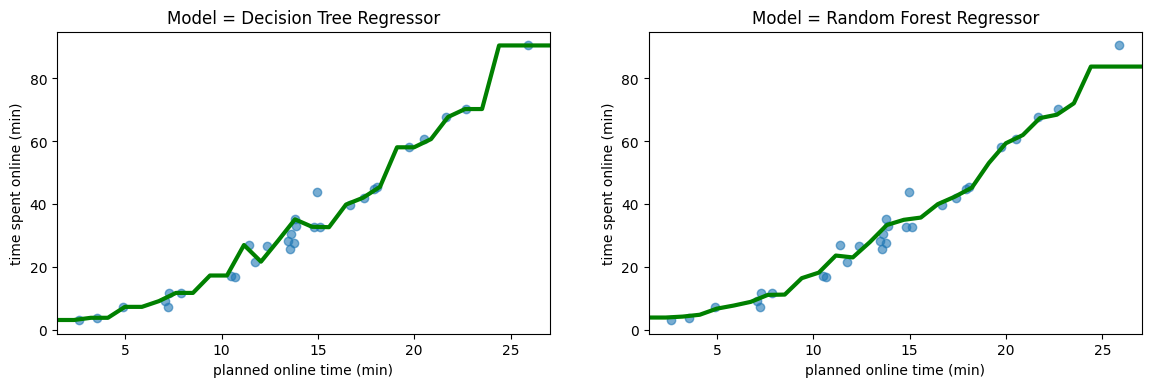

In [22]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor

import numpy as np

import pandas as pd

X = np.asarray(df['planned_minutes']).reshape(-1,1)

y = df['actual_minutes']

tree = DecisionTreeRegressor()

random_forest = RandomForestRegressor()

reg_tree = tree.fit(X,y)

reg_random_forest= random_forest.fit(X,y)

regs= [reg_tree ,reg_random_forest]

regression_name = ['Decision Tree Regressor','Random Forest Regressor']

titles = [f'Model = {name}' for name in regression_name]

compare_regression(X,y,regs,titles);

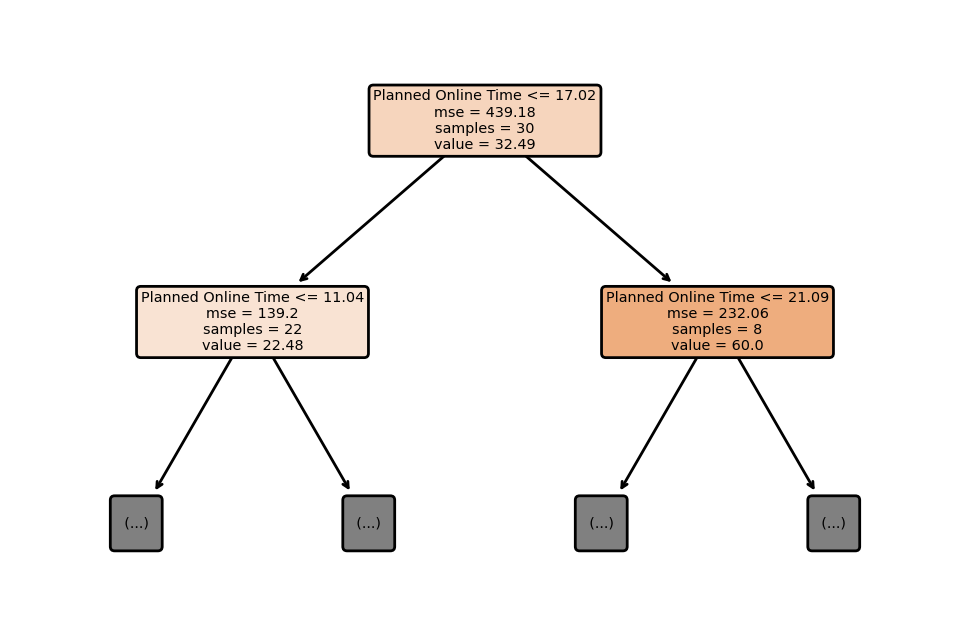

In [23]:
#Plotting our decision tree regresssor with max depth = 1

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
plot_tree(ax=ax, decision_tree=reg_tree, filled=True, max_depth=1, feature_names=['Planned Online Time'], rounded=True, precision=2);

🧠 Take your time to think about what happens in the `.fit()` method of the `DecisionTreeRegressor`. Can you list the main similarities and differences with a decision tree classifier?


🧠 When plotting the predictions of the decision tree and random forest with `.compare_regression()`, why are they so "bumpy" compare to linear or polynomial regression models?

🧠🧠 How are the predictions of each individual decision tree combined to make the numerical prediction of the random forest?

🧠 What do the `.compare_regression()` plots show about random forest regressors and regularization? 

💪💪 Feel free to investigate effect of various parameters on the regression models! You can use the same code structure as for the "analysis" section with the decision tree & random forest classifiers above. Remember that all parameters to play with are listed in the official documentation.

Investigating the effect of `min_samples_split` in DecisionTreeRegressor():

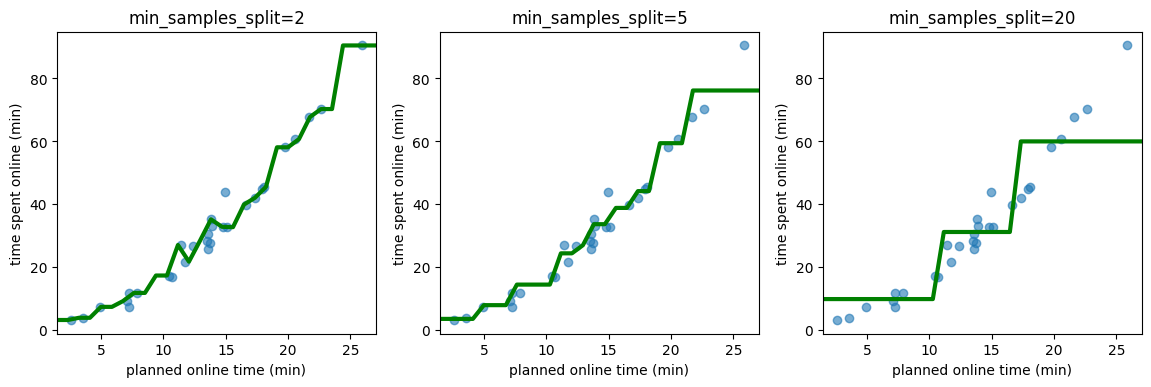

In [24]:
def train_tree_regression(X, y, **kwargs):
    clf = DecisionTreeRegressor(random_state=0, **kwargs)
    return clf.fit(X, y)

min_samples_split_values = [2, 5, 20]
trees = [train_tree_regression(X, y, min_samples_split=n) for n in min_samples_split_values]
titles = [f'min_samples_split={min_samples_split}' for min_samples_split in min_samples_split_values]

compare_regression(X, y, trees, titles)

`min_samples_split` Specifies the minimum number of samples required to split an internal code.

It helps to generalize the model and solve the problem of overfitting.

## 4. Summary

Today we learned about a flexible supervised learning model: **random forests**. We started by defining the the **decision tree** algorithm, and describing how it makes non-linear predictions with nested if-statements. We then went through its training procedure which uses **homogeneity metrics** or **variance reduction** to optimally split decision nodes. After noting these models' tendency to **overfit**, we introduced two **regularization** procedures: changing the trees' maximum depth, and **bagging**, which was our first example of ensemble learning. We then defined random forests as an **ensemble** of decision trees created through bagging and feature bagging.
Finally, we applied decision trees and random forest to two tasks: **classification** with the banknote authentication dataset, and **regression** with our instagram_planning dataset. We trained and visualized the models, as well as analysing the effect of various regularization parameters.

# Resources

## Core Resources


- [**Slides**](https://docs.google.com/presentation/d/1vpWA5RgGDv69ahG3B7kh4JozRu8LIxb29GMfRLk3KjQ/edit?usp=sharing)  
- [sklearn decision trees](https://scikit-learn.org/stable/modules/tree.html)  
Official documentation about the tree package, handy breakdown of tree models in sklearn
- [sklearn documentation - ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html)  
Official documentation about ensemble methods in sklearn
- [Introduction to random forests](https://victorzhou.com/blog/intro-to-random-forests/)  
Excellent visual blogpost which explains random forests in detail
- [Python data science handbook - random forests](https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html)  
Practical code-along post about implementation of random forests with sklearn


### Additional Resources

- [Understanding gini impurity](https://victorzhou.com/blog/gini-impurity/)  
Same blog from victor zhou going into the mathematics of gini impurity
- [random forest python](https://github.com/kevin-keraudren/randomforest-python)  
Implementation of random forest from scratch in python
- [Siraj - coding a random forest from scratch](https://youtu.be/QHOazyP-YlM)  
Siraj doing his thing and coding a random forest from scratch in half an hour.
- [Introduction to boosted trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)  
Comprehensive description of one of the most successful algorithms in data science: xgboost
- [args and kwargs demystified](https://realpython.com/python-kwargs-and-args/)  
blog post about \*\*kwargs in python
